In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import sys
from tqdm import tqdm

# <project_root>/ddnet/ddnet.py
sys.path.insert(0, os.path.join(os.path.abspath(''), '..', 'ddnet'))
import ddnet

Using TensorFlow backend.


# Initialize the setting

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
random.seed(123)

data_dir = os.path.join(os.path.abspath(''), '..', 'data', 'JHMDB')

# Create a config of Lite model (16 filters), 15 joints, 2D joint coordinates, 21 classes
# with this config, the model summary should  be
# Total params: 149,557
# Trainable params: 147,765
# Non-trainable params: 1,792
C = ddnet.DDNetConfig(frame_length=32, num_joints=15, joint_dim=2, num_classes=21, num_filters=16)

# Helper functions

In [4]:
def data_generator(T, C, le):
    X = T['pose'] # list of arrays
    Y = np.zeros(shape=(len(T['label']), C.clc_num)) # 2D array one-hot encoding of labels
    Y[range(Y.shape[0]), le.transform(T['label'])] = 1
    return X, Y

In [5]:
# helper functions for plotting
# history is a history object from keras
def plot_accuracy(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
def plot_loss(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()  

# Building the model

In [6]:
DD_Net = ddnet.create_DDNet(C)
DD_Net.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  (None, 32, 105)      0                                            
__________________________________________________________________________________________________
P (InputLayer)                  (None, 32, 15, 2)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 4, 128)       113056      M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
global_ma

# Train, Test and Save/Load the Model

In [7]:
Train = pickle.load(open(os.path.join(data_dir, "GT_train_1.pkl"), "rb"))
Test = pickle.load(open(os.path.join(data_dir, "GT_test_1.pkl"), "rb"))

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train['label'])

X, Y = data_generator(Train,C,le)
X_test,Y_test = data_generator(Test,C,le)

X_0, X_1 = ddnet.preprocess_batch(X, C)
X_test_0, X_test_1 = ddnet.preprocess_batch(X_test, C)

print(len(X), X_0.shape, X_1.shape, Y.shape)
print(len(X_test), X_test_0.shape, X_test_1.shape, Y.shape)

660 (660, 32, 105) (660, 32, 15, 2) (660, 21)
268 (268, 32, 105) (268, 32, 15, 2) (660, 21)


### Train and plot loss/accuracy

In [8]:
import keras
from keras.optimizers import *

lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=1e-5)

history1 = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=600,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )

lr = 1e-4
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history2 = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=500,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )



Train on 660 samples, validate on 268 samples
Epoch 1/600
660/660 [==============================] - 3s 4ms/step - loss: 3.7632 - accuracy: 0.0394 - val_loss: 3.0451 - val_accuracy: 0.0672
Epoch 2/600
660/660 [==============================] - 0s 154us/step - loss: 3.6529 - accuracy: 0.0636 - val_loss: 3.0444 - val_accuracy: 0.0224
Epoch 3/600
660/660 [==============================] - 0s 145us/step - loss: 3.4889 - accuracy: 0.0545 - val_loss: 3.0433 - val_accuracy: 0.0485
Epoch 4/600
660/660 [==============================] - 0s 134us/step - loss: 3.4221 - accuracy: 0.0712 - val_loss: 3.0419 - val_accuracy: 0.0560
Epoch 5/600
660/660 [==============================] - 0s 135us/step - loss: 3.3118 - accuracy: 0.0985 - val_loss: 3.0400 - val_accuracy: 0.0672
Epoch 6/600
660/660 [==============================] - 0s 139us/step - loss: 3.1960 - accuracy: 0.0939 - val_loss: 3.0379 - val_accuracy: 0.0858
Epoch 7/600
660/660 [==============================] - 0s 132us/step - loss: 3.1705 -

Epoch 56/600
660/660 [==============================] - 0s 138us/step - loss: 1.7815 - accuracy: 0.4242 - val_loss: 3.0942 - val_accuracy: 0.0858
Epoch 57/600
660/660 [==============================] - 0s 173us/step - loss: 1.8026 - accuracy: 0.4106 - val_loss: 3.0932 - val_accuracy: 0.0858
Epoch 58/600
660/660 [==============================] - 0s 187us/step - loss: 1.8143 - accuracy: 0.4273 - val_loss: 3.0937 - val_accuracy: 0.0896
Epoch 59/600
660/660 [==============================] - 0s 131us/step - loss: 1.7468 - accuracy: 0.4318 - val_loss: 3.0942 - val_accuracy: 0.0933
Epoch 60/600
660/660 [==============================] - 0s 167us/step - loss: 1.7580 - accuracy: 0.4379 - val_loss: 3.0935 - val_accuracy: 0.1007
Epoch 61/600
660/660 [==============================] - 0s 156us/step - loss: 1.7327 - accuracy: 0.4455 - val_loss: 3.0926 - val_accuracy: 0.1045
Epoch 62/600
660/660 [==============================] - 0s 220us/step - loss: 1.6576 - accuracy: 0.4682 - val_loss: 3.0908 -

660/660 [==============================] - 0s 124us/step - loss: 0.9997 - accuracy: 0.6909 - val_loss: 3.1136 - val_accuracy: 0.2351
Epoch 113/600
660/660 [==============================] - 0s 131us/step - loss: 1.0396 - accuracy: 0.6727 - val_loss: 3.1010 - val_accuracy: 0.2388
Epoch 114/600
660/660 [==============================] - 0s 126us/step - loss: 1.0784 - accuracy: 0.6530 - val_loss: 3.0917 - val_accuracy: 0.2388
Epoch 115/600
660/660 [==============================] - 0s 126us/step - loss: 1.0203 - accuracy: 0.6621 - val_loss: 3.0844 - val_accuracy: 0.2463
Epoch 116/600
660/660 [==============================] - 0s 133us/step - loss: 1.0307 - accuracy: 0.6773 - val_loss: 3.0836 - val_accuracy: 0.2463
Epoch 117/600
660/660 [==============================] - 0s 129us/step - loss: 1.0221 - accuracy: 0.6955 - val_loss: 3.0865 - val_accuracy: 0.2575
Epoch 118/600
660/660 [==============================] - 0s 129us/step - loss: 0.9839 - accuracy: 0.6697 - val_loss: 3.0905 - val_ac

Epoch 168/600
660/660 [==============================] - 0s 128us/step - loss: 0.8611 - accuracy: 0.7303 - val_loss: 3.2633 - val_accuracy: 0.2761
Epoch 169/600
660/660 [==============================] - 0s 122us/step - loss: 0.8870 - accuracy: 0.7545 - val_loss: 3.2628 - val_accuracy: 0.2761
Epoch 170/600
660/660 [==============================] - 0s 131us/step - loss: 0.8501 - accuracy: 0.7318 - val_loss: 3.2618 - val_accuracy: 0.2799
Epoch 171/600
660/660 [==============================] - 0s 121us/step - loss: 0.9044 - accuracy: 0.7045 - val_loss: 3.2603 - val_accuracy: 0.2799
Epoch 172/600
660/660 [==============================] - 0s 129us/step - loss: 0.8793 - accuracy: 0.7136 - val_loss: 3.2600 - val_accuracy: 0.2799
Epoch 173/600
660/660 [==============================] - 0s 130us/step - loss: 0.8539 - accuracy: 0.7348 - val_loss: 3.2596 - val_accuracy: 0.2799
Epoch 174/600
660/660 [==============================] - 0s 133us/step - loss: 0.8816 - accuracy: 0.7197 - val_loss: 3

Epoch 224/600
660/660 [==============================] - 0s 134us/step - loss: 0.8477 - accuracy: 0.7424 - val_loss: 3.0799 - val_accuracy: 0.3097
Epoch 225/600
660/660 [==============================] - 0s 128us/step - loss: 0.9017 - accuracy: 0.7015 - val_loss: 3.0740 - val_accuracy: 0.3097
Epoch 226/600
660/660 [==============================] - 0s 130us/step - loss: 0.8667 - accuracy: 0.7197 - val_loss: 3.0690 - val_accuracy: 0.3097
Epoch 227/600
660/660 [==============================] - 0s 127us/step - loss: 0.8699 - accuracy: 0.7182 - val_loss: 3.0637 - val_accuracy: 0.3172
Epoch 228/600
660/660 [==============================] - 0s 126us/step - loss: 0.8237 - accuracy: 0.7470 - val_loss: 3.0586 - val_accuracy: 0.3172
Epoch 229/600
660/660 [==============================] - 0s 126us/step - loss: 0.9037 - accuracy: 0.7227 - val_loss: 3.0532 - val_accuracy: 0.3209
Epoch 230/600
660/660 [==============================] - 0s 127us/step - loss: 0.8797 - accuracy: 0.7303 - val_loss: 3

Epoch 280/600
660/660 [==============================] - 0s 126us/step - loss: 0.7938 - accuracy: 0.7515 - val_loss: 2.7401 - val_accuracy: 0.3843
Epoch 281/600
660/660 [==============================] - 0s 120us/step - loss: 0.9031 - accuracy: 0.7303 - val_loss: 2.7343 - val_accuracy: 0.3843
Epoch 282/600
660/660 [==============================] - 0s 120us/step - loss: 0.8674 - accuracy: 0.7394 - val_loss: 2.7281 - val_accuracy: 0.3843
Epoch 283/600
660/660 [==============================] - 0s 120us/step - loss: 0.8645 - accuracy: 0.7303 - val_loss: 2.7214 - val_accuracy: 0.3843
Epoch 284/600
660/660 [==============================] - 0s 123us/step - loss: 0.8400 - accuracy: 0.7485 - val_loss: 2.7151 - val_accuracy: 0.3843
Epoch 285/600
660/660 [==============================] - 0s 119us/step - loss: 0.8731 - accuracy: 0.7439 - val_loss: 2.7087 - val_accuracy: 0.3843
Epoch 286/600
660/660 [==============================] - 0s 129us/step - loss: 0.8476 - accuracy: 0.7485 - val_loss: 2

Epoch 336/600
660/660 [==============================] - 0s 123us/step - loss: 0.8424 - accuracy: 0.7318 - val_loss: 2.4034 - val_accuracy: 0.4067
Epoch 337/600
660/660 [==============================] - 0s 122us/step - loss: 0.8365 - accuracy: 0.7485 - val_loss: 2.3979 - val_accuracy: 0.4104
Epoch 338/600
660/660 [==============================] - 0s 123us/step - loss: 0.8529 - accuracy: 0.7182 - val_loss: 2.3922 - val_accuracy: 0.4104
Epoch 339/600
660/660 [==============================] - 0s 119us/step - loss: 0.8042 - accuracy: 0.7439 - val_loss: 2.3868 - val_accuracy: 0.4104
Epoch 340/600
660/660 [==============================] - 0s 121us/step - loss: 0.8653 - accuracy: 0.7136 - val_loss: 2.3810 - val_accuracy: 0.4104
Epoch 341/600
660/660 [==============================] - 0s 119us/step - loss: 0.8316 - accuracy: 0.7485 - val_loss: 2.3755 - val_accuracy: 0.4142
Epoch 342/600
660/660 [==============================] - 0s 123us/step - loss: 0.8444 - accuracy: 0.7470 - val_loss: 2

Epoch 392/600
660/660 [==============================] - 0s 131us/step - loss: 0.8535 - accuracy: 0.7409 - val_loss: 2.1216 - val_accuracy: 0.4813
Epoch 393/600
660/660 [==============================] - 0s 130us/step - loss: 0.8519 - accuracy: 0.7273 - val_loss: 2.1171 - val_accuracy: 0.4813
Epoch 394/600
660/660 [==============================] - 0s 122us/step - loss: 0.8241 - accuracy: 0.7273 - val_loss: 2.1127 - val_accuracy: 0.4813
Epoch 395/600
660/660 [==============================] - 0s 134us/step - loss: 0.8639 - accuracy: 0.7348 - val_loss: 2.1083 - val_accuracy: 0.4851
Epoch 396/600
660/660 [==============================] - 0s 125us/step - loss: 0.8518 - accuracy: 0.7348 - val_loss: 2.1036 - val_accuracy: 0.4851
Epoch 397/600
660/660 [==============================] - 0s 125us/step - loss: 0.9093 - accuracy: 0.7273 - val_loss: 2.0991 - val_accuracy: 0.4851
Epoch 398/600
660/660 [==============================] - 0s 121us/step - loss: 0.8525 - accuracy: 0.7288 - val_loss: 2

Epoch 448/600
660/660 [==============================] - 0s 119us/step - loss: 0.8200 - accuracy: 0.7455 - val_loss: 1.8749 - val_accuracy: 0.5187
Epoch 449/600
660/660 [==============================] - 0s 126us/step - loss: 0.8305 - accuracy: 0.7394 - val_loss: 1.8709 - val_accuracy: 0.5187
Epoch 450/600
660/660 [==============================] - 0s 123us/step - loss: 0.8170 - accuracy: 0.7424 - val_loss: 1.8667 - val_accuracy: 0.5187
Epoch 451/600
660/660 [==============================] - 0s 123us/step - loss: 0.8383 - accuracy: 0.7394 - val_loss: 1.8626 - val_accuracy: 0.5187
Epoch 452/600
660/660 [==============================] - 0s 129us/step - loss: 0.8377 - accuracy: 0.7288 - val_loss: 1.8585 - val_accuracy: 0.5187
Epoch 453/600
660/660 [==============================] - 0s 119us/step - loss: 0.8242 - accuracy: 0.7606 - val_loss: 1.8545 - val_accuracy: 0.5187
Epoch 454/600
660/660 [==============================] - 0s 120us/step - loss: 0.8426 - accuracy: 0.7258 - val_loss: 1

Epoch 504/600
660/660 [==============================] - 0s 121us/step - loss: 0.7996 - accuracy: 0.7606 - val_loss: 1.6615 - val_accuracy: 0.5485
Epoch 505/600
660/660 [==============================] - 0s 124us/step - loss: 0.8375 - accuracy: 0.7439 - val_loss: 1.6579 - val_accuracy: 0.5485
Epoch 506/600
660/660 [==============================] - 0s 124us/step - loss: 0.7884 - accuracy: 0.7439 - val_loss: 1.6542 - val_accuracy: 0.5522
Epoch 507/600
660/660 [==============================] - 0s 124us/step - loss: 0.8714 - accuracy: 0.7227 - val_loss: 1.6506 - val_accuracy: 0.5522
Epoch 508/600
660/660 [==============================] - 0s 123us/step - loss: 0.8210 - accuracy: 0.7439 - val_loss: 1.6475 - val_accuracy: 0.5522
Epoch 509/600
660/660 [==============================] - 0s 129us/step - loss: 0.8543 - accuracy: 0.7242 - val_loss: 1.6442 - val_accuracy: 0.5522
Epoch 510/600
660/660 [==============================] - 0s 127us/step - loss: 0.8320 - accuracy: 0.7530 - val_loss: 1

Epoch 560/600
660/660 [==============================] - 0s 123us/step - loss: 0.8308 - accuracy: 0.7561 - val_loss: 1.4868 - val_accuracy: 0.5784
Epoch 561/600
660/660 [==============================] - 0s 121us/step - loss: 0.8333 - accuracy: 0.7500 - val_loss: 1.4840 - val_accuracy: 0.5858
Epoch 562/600
660/660 [==============================] - 0s 128us/step - loss: 0.8050 - accuracy: 0.7455 - val_loss: 1.4811 - val_accuracy: 0.5858
Epoch 563/600
660/660 [==============================] - 0s 119us/step - loss: 0.8562 - accuracy: 0.7333 - val_loss: 1.4785 - val_accuracy: 0.5858
Epoch 564/600
660/660 [==============================] - 0s 124us/step - loss: 0.8387 - accuracy: 0.7515 - val_loss: 1.4757 - val_accuracy: 0.5858
Epoch 565/600
660/660 [==============================] - 0s 124us/step - loss: 0.8343 - accuracy: 0.7439 - val_loss: 1.4729 - val_accuracy: 0.5858
Epoch 566/600
660/660 [==============================] - 0s 128us/step - loss: 0.8392 - accuracy: 0.7364 - val_loss: 1

Epoch 16/500
660/660 [==============================] - 0s 129us/step - loss: 0.8130 - accuracy: 0.7303 - val_loss: 1.3467 - val_accuracy: 0.6194
Epoch 17/500
660/660 [==============================] - 0s 129us/step - loss: 0.8255 - accuracy: 0.7530 - val_loss: 1.3444 - val_accuracy: 0.6194
Epoch 18/500
660/660 [==============================] - 0s 136us/step - loss: 0.8006 - accuracy: 0.7576 - val_loss: 1.3425 - val_accuracy: 0.6231
Epoch 19/500
660/660 [==============================] - 0s 131us/step - loss: 0.7901 - accuracy: 0.7515 - val_loss: 1.3407 - val_accuracy: 0.6231
Epoch 20/500
660/660 [==============================] - 0s 137us/step - loss: 0.7986 - accuracy: 0.7545 - val_loss: 1.3386 - val_accuracy: 0.6231
Epoch 21/500
660/660 [==============================] - 0s 132us/step - loss: 0.8106 - accuracy: 0.7379 - val_loss: 1.3367 - val_accuracy: 0.6231
Epoch 22/500
660/660 [==============================] - 0s 132us/step - loss: 0.8307 - accuracy: 0.7197 - val_loss: 1.3346 -

Epoch 73/500
660/660 [==============================] - 0s 149us/step - loss: 0.8410 - accuracy: 0.7394 - val_loss: 1.2513 - val_accuracy: 0.6455
Epoch 74/500
660/660 [==============================] - 0s 140us/step - loss: 0.8254 - accuracy: 0.7500 - val_loss: 1.2500 - val_accuracy: 0.6455
Epoch 75/500
660/660 [==============================] - 0s 142us/step - loss: 0.8170 - accuracy: 0.7591 - val_loss: 1.2488 - val_accuracy: 0.6455
Epoch 76/500
660/660 [==============================] - 0s 154us/step - loss: 0.8122 - accuracy: 0.7333 - val_loss: 1.2475 - val_accuracy: 0.6455
Epoch 77/500
660/660 [==============================] - 0s 137us/step - loss: 0.8146 - accuracy: 0.7576 - val_loss: 1.2461 - val_accuracy: 0.6455
Epoch 78/500
660/660 [==============================] - 0s 134us/step - loss: 0.7660 - accuracy: 0.7636 - val_loss: 1.2449 - val_accuracy: 0.6455
Epoch 79/500
660/660 [==============================] - 0s 135us/step - loss: 0.7578 - accuracy: 0.7727 - val_loss: 1.2436 -

Epoch 129/500
660/660 [==============================] - 0s 149us/step - loss: 0.8489 - accuracy: 0.7394 - val_loss: 1.1953 - val_accuracy: 0.6567
Epoch 130/500
660/660 [==============================] - 0s 131us/step - loss: 0.8049 - accuracy: 0.7742 - val_loss: 1.1946 - val_accuracy: 0.6567
Epoch 131/500
660/660 [==============================] - 0s 140us/step - loss: 0.8108 - accuracy: 0.7621 - val_loss: 1.1938 - val_accuracy: 0.6567
Epoch 132/500
660/660 [==============================] - 0s 134us/step - loss: 0.7729 - accuracy: 0.7727 - val_loss: 1.1930 - val_accuracy: 0.6567
Epoch 133/500
660/660 [==============================] - 0s 130us/step - loss: 0.7812 - accuracy: 0.7621 - val_loss: 1.1924 - val_accuracy: 0.6567
Epoch 134/500
660/660 [==============================] - 0s 134us/step - loss: 0.8036 - accuracy: 0.7515 - val_loss: 1.1915 - val_accuracy: 0.6567
Epoch 135/500
660/660 [==============================] - 0s 127us/step - loss: 0.8541 - accuracy: 0.7273 - val_loss: 1

Epoch 185/500
660/660 [==============================] - 0s 127us/step - loss: 0.8029 - accuracy: 0.7409 - val_loss: 1.1644 - val_accuracy: 0.6604
Epoch 186/500
660/660 [==============================] - 0s 125us/step - loss: 0.8408 - accuracy: 0.7152 - val_loss: 1.1640 - val_accuracy: 0.6604
Epoch 187/500
660/660 [==============================] - 0s 131us/step - loss: 0.8390 - accuracy: 0.7424 - val_loss: 1.1637 - val_accuracy: 0.6604
Epoch 188/500
660/660 [==============================] - 0s 127us/step - loss: 0.7776 - accuracy: 0.7636 - val_loss: 1.1631 - val_accuracy: 0.6604
Epoch 189/500
660/660 [==============================] - 0s 122us/step - loss: 0.8274 - accuracy: 0.7455 - val_loss: 1.1625 - val_accuracy: 0.6604
Epoch 190/500
660/660 [==============================] - 0s 131us/step - loss: 0.7807 - accuracy: 0.7455 - val_loss: 1.1621 - val_accuracy: 0.6604
Epoch 191/500
660/660 [==============================] - 0s 134us/step - loss: 0.8195 - accuracy: 0.7545 - val_loss: 1

Epoch 241/500
660/660 [==============================] - 0s 121us/step - loss: 0.8462 - accuracy: 0.7303 - val_loss: 1.1433 - val_accuracy: 0.6567
Epoch 242/500
660/660 [==============================] - 0s 124us/step - loss: 0.8533 - accuracy: 0.7303 - val_loss: 1.1429 - val_accuracy: 0.6567
Epoch 243/500
660/660 [==============================] - 0s 124us/step - loss: 0.7984 - accuracy: 0.7455 - val_loss: 1.1426 - val_accuracy: 0.6567
Epoch 244/500
660/660 [==============================] - 0s 122us/step - loss: 0.7680 - accuracy: 0.7500 - val_loss: 1.1423 - val_accuracy: 0.6567
Epoch 245/500
660/660 [==============================] - 0s 120us/step - loss: 0.7637 - accuracy: 0.7621 - val_loss: 1.1422 - val_accuracy: 0.6567
Epoch 246/500
660/660 [==============================] - 0s 137us/step - loss: 0.7950 - accuracy: 0.7530 - val_loss: 1.1418 - val_accuracy: 0.6567
Epoch 247/500
660/660 [==============================] - 0s 123us/step - loss: 0.8034 - accuracy: 0.7621 - val_loss: 1

Epoch 297/500
660/660 [==============================] - 0s 120us/step - loss: 0.7821 - accuracy: 0.7576 - val_loss: 1.1300 - val_accuracy: 0.6493
Epoch 298/500
660/660 [==============================] - 0s 121us/step - loss: 0.7517 - accuracy: 0.7742 - val_loss: 1.1298 - val_accuracy: 0.6493
Epoch 299/500
660/660 [==============================] - 0s 120us/step - loss: 0.8038 - accuracy: 0.7530 - val_loss: 1.1296 - val_accuracy: 0.6493
Epoch 300/500
660/660 [==============================] - 0s 119us/step - loss: 0.7516 - accuracy: 0.7727 - val_loss: 1.1294 - val_accuracy: 0.6493
Epoch 301/500
660/660 [==============================] - 0s 120us/step - loss: 0.8138 - accuracy: 0.7500 - val_loss: 1.1293 - val_accuracy: 0.6493
Epoch 302/500
660/660 [==============================] - 0s 119us/step - loss: 0.8021 - accuracy: 0.7606 - val_loss: 1.1293 - val_accuracy: 0.6493
Epoch 303/500
660/660 [==============================] - 0s 122us/step - loss: 0.7750 - accuracy: 0.7636 - val_loss: 1

Epoch 353/500
660/660 [==============================] - 0s 137us/step - loss: 0.7897 - accuracy: 0.7470 - val_loss: 1.1228 - val_accuracy: 0.6567
Epoch 354/500
660/660 [==============================] - 0s 130us/step - loss: 0.7945 - accuracy: 0.7576 - val_loss: 1.1226 - val_accuracy: 0.6567
Epoch 355/500
660/660 [==============================] - 0s 126us/step - loss: 0.7669 - accuracy: 0.7773 - val_loss: 1.1225 - val_accuracy: 0.6567
Epoch 356/500
660/660 [==============================] - 0s 127us/step - loss: 0.7896 - accuracy: 0.7530 - val_loss: 1.1224 - val_accuracy: 0.6567
Epoch 357/500
660/660 [==============================] - 0s 126us/step - loss: 0.7972 - accuracy: 0.7470 - val_loss: 1.1224 - val_accuracy: 0.6567
Epoch 358/500
660/660 [==============================] - 0s 128us/step - loss: 0.7826 - accuracy: 0.7576 - val_loss: 1.1222 - val_accuracy: 0.6567
Epoch 359/500
660/660 [==============================] - 0s 120us/step - loss: 0.7916 - accuracy: 0.7424 - val_loss: 1

Epoch 409/500
660/660 [==============================] - 0s 124us/step - loss: 0.7593 - accuracy: 0.7591 - val_loss: 1.1183 - val_accuracy: 0.6567
Epoch 410/500
660/660 [==============================] - 0s 124us/step - loss: 0.7997 - accuracy: 0.7652 - val_loss: 1.1183 - val_accuracy: 0.6567
Epoch 411/500
660/660 [==============================] - 0s 126us/step - loss: 0.8127 - accuracy: 0.7439 - val_loss: 1.1182 - val_accuracy: 0.6567
Epoch 412/500
660/660 [==============================] - 0s 123us/step - loss: 0.7599 - accuracy: 0.7697 - val_loss: 1.1183 - val_accuracy: 0.6567
Epoch 413/500
660/660 [==============================] - 0s 126us/step - loss: 0.8239 - accuracy: 0.7409 - val_loss: 1.1182 - val_accuracy: 0.6567
Epoch 414/500
660/660 [==============================] - 0s 121us/step - loss: 0.7654 - accuracy: 0.7652 - val_loss: 1.1181 - val_accuracy: 0.6567
Epoch 415/500
660/660 [==============================] - 0s 123us/step - loss: 0.7623 - accuracy: 0.7621 - val_loss: 1

Epoch 465/500
660/660 [==============================] - 0s 121us/step - loss: 0.7659 - accuracy: 0.7742 - val_loss: 1.1158 - val_accuracy: 0.6567
Epoch 466/500
660/660 [==============================] - 0s 125us/step - loss: 0.7746 - accuracy: 0.7561 - val_loss: 1.1157 - val_accuracy: 0.6567
Epoch 467/500
660/660 [==============================] - 0s 120us/step - loss: 0.7903 - accuracy: 0.7621 - val_loss: 1.1157 - val_accuracy: 0.6567
Epoch 468/500
660/660 [==============================] - 0s 122us/step - loss: 0.7993 - accuracy: 0.7636 - val_loss: 1.1156 - val_accuracy: 0.6604
Epoch 469/500
660/660 [==============================] - 0s 126us/step - loss: 0.7992 - accuracy: 0.7500 - val_loss: 1.1155 - val_accuracy: 0.6604
Epoch 470/500
660/660 [==============================] - 0s 119us/step - loss: 0.7987 - accuracy: 0.7576 - val_loss: 1.1154 - val_accuracy: 0.6567
Epoch 471/500
660/660 [==============================] - 0s 123us/step - loss: 0.7987 - accuracy: 0.7485 - val_loss: 1

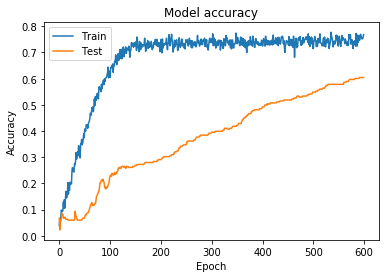

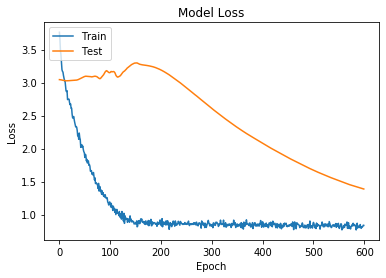

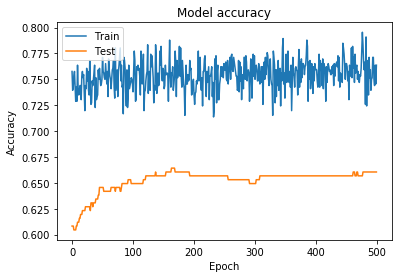

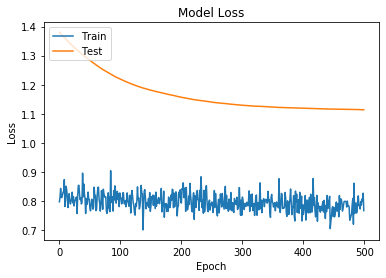

In [9]:
# the first 600 epochs
plot_accuracy(history1)
plot_loss(history1)
# the next 500 epochs
plot_accuracy(history2)
plot_loss(history2)

### Save/Load Model

In [10]:
model_path = 'jhmdb_lite_model.h5'
ddnet.save_DDNet(DD_Net, model_path)

In [11]:
# Load the model back from disk
new_net = ddnet.load_DDNet(model_path)
# Evaluate against test set, you should get the same accuracy
new_net.evaluate([X_test_0,X_test_1],Y_test)

268/268 [==============================] - 1s 3ms/step


[1.1139117995304848, 0.6604477763175964]